In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import *
from invariance_functions import * 
from invariance_kernels_2d import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [12]:

mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 2
max_v = 2
n_train = 3
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_v, max_v, (n_train))
train_starting_velocity2 = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

data2 = get_SHM_data_2D(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch


[1.7864198  1.03954649 0.81111603]
[-0.40124928  0.86759647  0.25922844]
[-0.69573343  1.57913459  0.63245328]
[ 0.39774547 -0.70667786  1.7852516 ]


In [3]:

scalerX = StandardScaler(with_mean=False, with_std=False).fit(data2[0])
scalerY = StandardScaler(with_mean=False, with_std=False).fit(data2[1])
#scalerX = MinMaxScaler((-1,1)).fit(data2[0])
#scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)
scalers = (scalerX, scalerY)
time_setting = (testing_time, time_step)
dynamics = (SHM_dynamics1_2D, SHM_dynamics2_2D)
jitter = 5e-4

#joblib.dump(scalerX, 'shm_2d/scalerX.gz')
#joblib.dump(scalerY, 'shm_2d/scalerY.gz')

In [8]:

print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())
#try:
n_neighbours =  20
print("known")
kernel_known = get_invariance_kernel_2D(SHMLocalInvariance2D, 3, 6, 0, 1, n_neighbours, jitter) #switch
#kernel_known = get_SHM_invariance_2D(1, n_neighbours, jitter) #switch
known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
print(known.log_marginal_likelihood().numpy())

polynomial_degree = 1
print("learnt")
#    X, Y = data
kernel = get_paramertised_invariance_kernel_2D(PolynomialLocalInvariance2D, 3, 6, 0, 1, n_neighbours, jitter, polynomial_degree) 
#kernel = get_polynomial_invariance_2D(1, n_neighbours, jitter, polynomial_degree) 
model = get_GPR_model_2D(kernel, mean, data, iterations=1000, old_model=known)
print(model.log_marginal_likelihood().numpy())
#    model = get_GPR_model_2D(kernel, mean, data, iterations=10000, old_kernel=kernel_known)
#    ckpt = tf.train.Checkpoint(model=model)
#    manager = tf.train.CheckpointManager(ckpt, "shm_2d", max_to_keep=3)
#    model = get_GPR_model_GD_2D(model=model, iterations=10000, lr=0.001, manager=manager)
#    print(model.log_marginal_likelihood().numpy())
#except tf.errors.InvalidArgumentError:
#    print("jitter too small")

moi
430.6233222115418
known
478.92219374989975
learnt
475.65355124638904


In [5]:

eva_future_moi = []
eva_future_known = []
eva_future_learnt = []

def energy(X):
    return 0.5*(tf.square(X[:,0])+tf.square(X[:,1])+tf.square(X[:,2])+tf.square(X[:,3]))
for i in range(10):
    print(i)
    test_starting_position1 = np.random.uniform(-max_x, max_x)
    test_starting_position2 = np.random.uniform(-max_x, max_x)
    test_starting_velocity1 = np.random.uniform(-max_v, max_v)
    test_starting_velocity2 = np.random.uniform(-max_v, max_v)
    test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
    print(test_starting)
    evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])
    evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_known.append(evaluate_known[0])
    print(evaluate_known[0])
    evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_learnt.append(evaluate_learnt[0])
    print(evaluate_learnt[0])

0
(0.5777656652212153, 1.1619728968424936, 1.0859763363861195, -1.4025365999024713)
0.04588385631659517
0.006215343826146946
0.006253336028585821
1
(-0.8093774821962563, 1.4895003182541333, 1.3813572464138542, -0.45301867298032983)
0.030225713462434096
0.0010836732077024313
0.0010890588940778779
2
(0.7678892593711133, -1.9543233418160284, 0.7404589113007813, -1.704483220353187)
0.009633705101126428
0.005077912612992518
0.004892617288197817
3
(1.4845416971967138, 0.7895414558871763, 0.48298261895098227, -1.029119050632711)
0.014643708895334341
0.0021302512211915595
0.002126033019621654
4
(0.20735845345546133, -1.0418497107784463, 1.4670483665801672, -0.34968326170669517)
0.0043127131171276445
0.004594008704047479
0.004554383983392707
5
(-1.8485946869018335, 0.7599108080808485, -1.981633577949495, -0.14849736113686518)
0.009677793354177395
0.0019950283827501643
0.0019640178707412887
6
(1.5220826135365662, 1.142734961025198, -0.9403651057368019, -0.9927136219724422)
0.022592933505421273
0

In [6]:

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = model.log_marginal_likelihood().numpy()
print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") + " & "+' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_known),".4f")+" & "+format((np.mean(eva_future_learnt)),".4f")+ ' \\\\')

Log Marginal Likelihood & 430.62 & 478.70 & 475.42 &  \\
MSE & 0.0271 & 0.0035 & 0.0035 \\


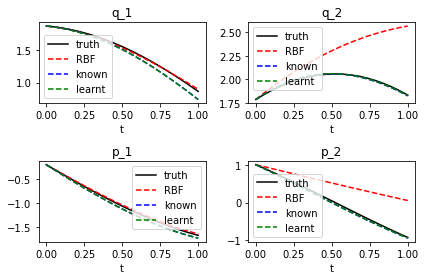

In [8]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,evaluate_known[4][:,0],label="truth", color="black")
axs[0][0].plot(t,evaluate_moi[1][:,0], "--", label="RBF", color="red")
axs[0][0].plot(t,evaluate_known[1][:,0], "--", label="known", color="blue")
axs[0][0].plot(t,evaluate_learnt[1][:,0], "--", label="learnt", color="green")
axs[0][0].set_title("q_1")
axs[0][0].set_xlabel("t")
axs[0][0].legend()

axs[0][1].plot(t,evaluate_known[4][:,1],label="truth", color="black")
axs[0][1].plot(t,evaluate_moi[1][:,1], "--", label="RBF", color="red")
axs[0][1].plot(t,evaluate_known[1][:,1], "--", label="known", color="blue")
axs[0][1].plot(t,evaluate_learnt[1][:,1], "--", label="learnt", color="green")
axs[0][1].set_title("q_2")
axs[1][1].set_xlabel("t")
axs[0][1].legend()

axs[1][0].plot(t,evaluate_known[4][:,2],label="truth", color="black")
axs[1][0].plot(t,evaluate_moi[1][:,2], "--", label="RBF", color="red")
axs[1][0].plot(t,evaluate_known[1][:,2], "--", label="known", color="blue")
axs[1][0].plot(t,evaluate_learnt[1][:,2], "--", label="learnt", color="green")
axs[1][0].set_title("p_1")
axs[1][0].set_xlabel("t")
axs[1][0].legend()

axs[1][1].plot(t,evaluate_known[4][:,3],label="truth", color="black")
axs[1][1].plot(t,evaluate_moi[1][:,3], "--", label="RBF", color="red")
axs[1][1].plot(t,evaluate_known[1][:,3], "--", label="known", color="blue")
axs[1][1].plot(t,evaluate_learnt[1][:,3], "--", label="learnt", color="green")
axs[1][1].set_title("p_2")
axs[0][1].set_xlabel("t")
axs[1][1].legend()

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.tight_layout()
plt.savefig("figures/shm_2d_predicted.pdf")


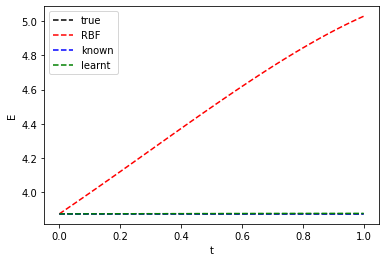

In [9]:

plt.plot(t, evaluate_learnt[5], "--",label="true", color="black")
plt.plot(t, evaluate_moi[6], "--",label="RBF", color="red")
plt.plot(t, evaluate_known[6], "--",label="known", color="blue")
plt.plot(t, evaluate_learnt[6], "--",label="learnt", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
plt.savefig("figures/shm_2d_energy.pdf")

In [ ]:
n_neighbours = 20
def energy(X):
    return 0.5*(tf.square(X[:,0])+tf.square(X[:,1])+tf.square(X[:,2])+tf.square(X[:,3]))
print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())

print("known")
kernel_known = get_invariance_kernel_2D(SHMLocalInvariance2D, 3, 6, 0, 1, n_neighbours, jitter)
known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
print(known.log_marginal_likelihood().numpy())


print("fixed")
kernel = get_paramertised_invariance_kernel_2D(PolynomialLocalInvariance2D, 3, 6, 0, 1, n_neighbours, jitter, polynomial_degree)
model = get_GPR_model_2D(kernel, mean, data, iterations=1000, old_model=known, fixed=True)

print(model.log_marginal_likelihood().numpy())

print("free")
kernel_free = get_paramertised_invariance_kernel_2D(PolynomialLocalInvariance2D, 3, 6, 0, 1, n_neighbours, jitter, polynomial_degree)
model_free = get_GPR_model_2D(kernel_free, mean, data, iterations=1000, old_model=known)
print(model_free.log_marginal_likelihood().numpy())


polynomial_degree = 1
print("learnt")
test_starting_position1 = np.random.uniform(-max_x, max_x)
test_starting_position2 = np.random.uniform(-max_x, max_x)
test_starting_velocity1 = np.random.uniform(-max_v, max_v)
test_starting_velocity2 = np.random.uniform(-max_v, max_v)
test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
 

evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_moi[0])
evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_known[0])
evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_learnt[0])
evaluate_learnt_free = evaluate_model_future_2D(model_free, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_learnt_free[0])


grids_lml = []
grids_eva = []
for i in range(50):
    print(i)
    kernel_grid = get_paramertised_invariance_kernel_2D(PolynomialLocalInvariance2D, 3, 6, 0, 1, n_neighbours, jitter, polynomial_degree)
    kernel_grid.poly = gpflow.Parameter(0.1*np.random.normal(size=kernel_grid.poly.shape), transform =tfp.bijectors.Sigmoid(to_default_float(-1.), to_default_float(1.)), trainable=False, prior=tfp.distributions.Laplace(to_default_float(0),(0.1)), name="poly")
    model_grid = get_GPR_model_2D(kernel_grid, mean, data, iterations=1000, old_model=known, fixed=True)
    print(model_grid.log_marginal_likelihood().numpy())

    evaluate_learnt_grid = evaluate_model_future_2D(model_grid, test_starting, dynamics, time_setting, scalers, energy)
    print(evaluate_learnt_grid[0])
    grids_eva.append(evaluate_learnt_grid[0])
    grids_lml.append(model_grid.log_marginal_likelihood().numpy())
    if i>=2:
        print(pearsonr(grids_lml, grids_eva))
        print(spearmanr(grids_lml, grids_eva))


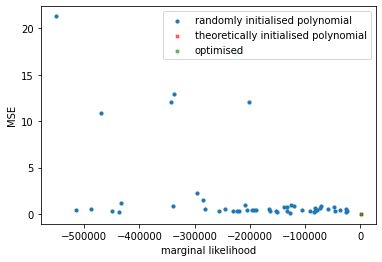

In [33]:
plt.scatter(grids_lml, grids_eva, s=10, label="randomly initialised polynomial")
plt.scatter(model.log_marginal_likelihood().numpy(), evaluate_learnt[0],marker="X",s=10, color="red", label="theoretically initialised polynomial", alpha=0.5)
plt.scatter(model_free.log_marginal_likelihood().numpy(), evaluate_learnt_free[0], s=10, color="green", label="optimised", alpha=0.5)
#plt.scatter(known.log_marginal_likelihood().numpy(), evaluate_learnt_free[0], s=10, color="orange", label="known", alpha=0.5)
#plt.scatter(moi.log_marginal_likelihood().numpy(),evaluate_moi[0], s=10, color="purple", label="RBF")
plt.plot()
plt.xlabel("marginal likelihood")
plt.ylabel("MSE")
plt.legend()
plt.savefig("figures/shm_2d_polynomial.pdf")



In [34]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(grids_lml, grids_eva))
print(spearmanr(grids_lml, grids_eva))

(-0.4274269959284613, 0.001961790846245755)
SpearmanrResult(correlation=-0.3210084033613445, pvalue=0.02302712281614547)
